**Investigating Heart disease**

Heart disease is the leading cause of death across America. If we can understand it better using statistical models we can hopefully devise methods to detect the signs early. There are many different factors than can contribute to this disease, some of which may be missing from the dataset I am working with due mainly to the sheer number of them. However, using what we have can shed plenty of light on the nature of this problem. 

There are two goals in this project.The first is to get a better understanding of how some of these factors contribute to the overall scheme of things. The second is to build and validate models that will allow us to classify whether or not a patient has heart disease based on their symptoms.

Lets get started by first setting up our required libraries.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as tree
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['heart.csv']


**Reading and Cleaning the Data**

Here is where we gather our data from our csv file. 

In [2]:
data = pd.read_csv("../input/heart.csv")
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


One thing to note from an initial inspection is that some of the data is represented as dummy variables. The descriptions for these variables can be found in the dataset's documentation. 

Before we proceed, it is a good idea to check whether or not we need to clean up the data. The following code checks if there is any missing entries.

In [3]:
data.isnull().values.any()

False

Thankfully all the columns are filled in; however, I want to make the data more intuitive to look at, thus we can replace the dummy variables using the dataset's documentation. Despite my desire to make the data more intuitive, it would be wise to keep all our dummy variables intact to avoid a headache when we are ready to build our models. Therefore, I will make a copy of the dataframe and fill it in with intuitive information. The 'intuitive' dataframe will be used for data exploration purposes, the original dataframe will be used for statistical analysis.

In [4]:
intuitive = data.copy()

intuitive['cp'] = intuitive['cp'].replace(0,'No pain')
intuitive['cp'] = intuitive['cp'].replace(1,'Typical-agina')
intuitive['cp'] = intuitive['cp'].replace(2,'Atypical-agina')
intuitive['cp'] = intuitive['cp'].replace(3,'Non-agina')
intuitive['cp'] = intuitive['cp'].replace(4,'Asymptomatic')
intuitive['sex'] = intuitive['sex'].replace(1,'male')
intuitive['sex'] = intuitive['sex'].replace(0,'female')
intuitive['fbs'] = intuitive['fbs'].replace(0,'Under 120 mg/dl')
intuitive['fbs'] = intuitive['fbs'].replace(1,'Over 120 mg/dl')
intuitive ['restecg'] = intuitive['restecg'].replace(0,'Normal')
intuitive ['restecg'] = intuitive['restecg'].replace(1,'Abnormal')
intuitive['exang'] = intuitive['exang'].replace(1,'yes')
intuitive['exang'] = intuitive['exang'].replace(0,'no')
intuitive['target'] = intuitive['target'].replace(0,'No Heart Disease')
intuitive['target'] = intuitive['target'].replace(1,'Has Heart Disease')

intuitive.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,male,Non-agina,145,233,Over 120 mg/dl,Normal,150,no,2.3,0,0,1,Has Heart Disease
1,37,male,Atypical-agina,130,250,Under 120 mg/dl,Abnormal,187,no,3.5,0,0,2,Has Heart Disease
2,41,female,Typical-agina,130,204,Under 120 mg/dl,Normal,172,no,1.4,2,0,2,Has Heart Disease
3,56,male,Typical-agina,120,236,Under 120 mg/dl,Abnormal,178,no,0.8,2,0,2,Has Heart Disease
4,57,female,No pain,120,354,Under 120 mg/dl,Abnormal,163,yes,0.6,2,0,2,Has Heart Disease


Now this is better. We are ready to begin data exploration.

**Data exploration and visualization**

First up, I'll load in the data and construct a heatmap. This heatmap can help us visualize what characteristics of heart disease are correlated.

Text(0.5, 1.0, 'Correlation of Physical Characteristics')

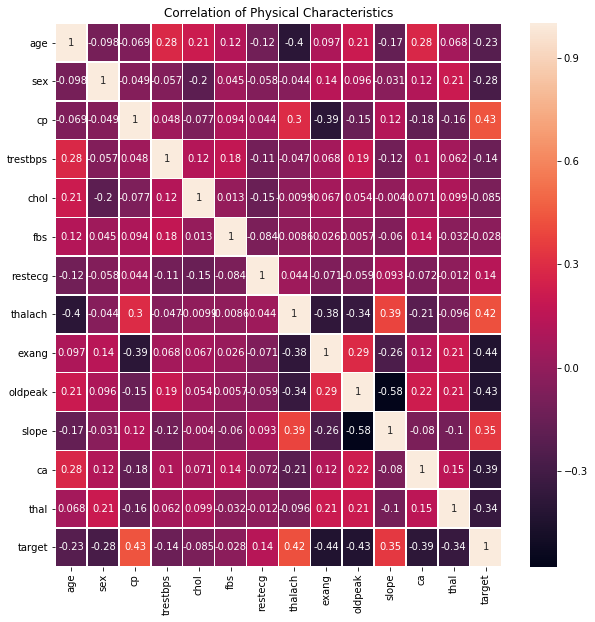

In [5]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(data.corr(), annot = True, linewidths=.5, ax = ax).set_title("Correlation of Physical Characteristics")

Suprisingly there are no strikingly high correlations between any two variables. The two highest correlation values for target come from thalach( maximum heartrate achieved) and cp( chest pain type). I expected the top two to come from blood pressure and cholesterol levels as these factors directly relate to the heart yet these have relatively low correlations to diagnosis.  Let us see some statistics for chest pain type and maximum heart rate.

In [6]:
data['cp'].mode()

0    0
dtype: int64

In [7]:
data['thalach'].describe()

count    303.000000
mean     149.646865
std       22.905161
min       71.000000
25%      133.500000
50%      153.000000
75%      166.000000
max      202.000000
Name: thalach, dtype: float64

Since the chest pain data was qualitative I was more interested in what was the most common chest pain type. It turns out typical agina was the most common type of chest pain. This type of pain can be identified by tightness in the chest area, shortness of breath and a sudden increase of perspiration. This chest pain is caused by blockages in the arteries resulting in the heart not getting enough oxygen. (Reference: https://www.harringtonhospital.org/typical-and-atypical-angina-what-to-look-for/)

Looking at the data for maximum heart rate, the average was 150 bpm. Using the formula well known formula MAX_HEARTRATE = (220 - AGE) we find that this average equates to the maximum heart rate for a 72 year old person. Now this begs the question: what does the age distribution look like?

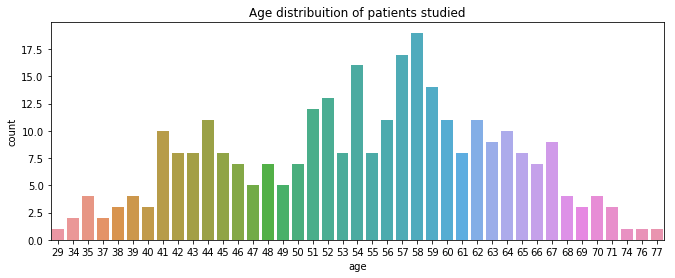

In [8]:
plt.figure(figsize=(11,4))
ax = sns.countplot(x = data['age']).set_title('Age distribuition of patients studied')

Now that is very interesting. Most people studied were in the age range of 50 through 60 and only a handful of patients were in their 70's. This can only mean that a majority of these patients exhibited a lower maximum heart rate than expected for their age. Why is this? Fortunately, that answer can be answered from our previous observation of chest pain. Remember, the most common type of chest pain is caused by semi clogged arteries. With less oxygen flowing into the heart, the heart will have a difficult time pumping out blood, hence a lower maximum heart rate. This also gives a physical explanation for why chest pain and heart rate had a noticible correlation on the heat map.

I now want to explore if a person's gender has any effect on anything. First lets look at the hand we're dealt.

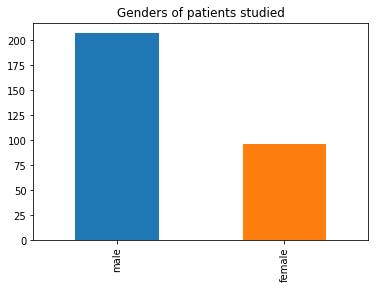

In [9]:
intuitive['sex'].value_counts().plot.bar(title = 'Genders of patients studied')

In [10]:
intuitive['sex'].value_counts()

male      207
female     96
Name: sex, dtype: int64

There were over twice the amount of male patients than there we female. This could be a bit problematic. If males exhibit different symptoms than women this would make this data biased towards males and it wouldnt fully capture what is going behind the scenes for females. 

Let us investigate the data gender specifically. First I will split the data by gender.  

In [11]:
is_female = intuitive['sex'] == 'female'
is_male = intuitive['sex'] == 'male'

all_females = intuitive[is_female]
all_males = intuitive[is_male]


Now let us revisit the age distribution

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Age Distribution of Females')

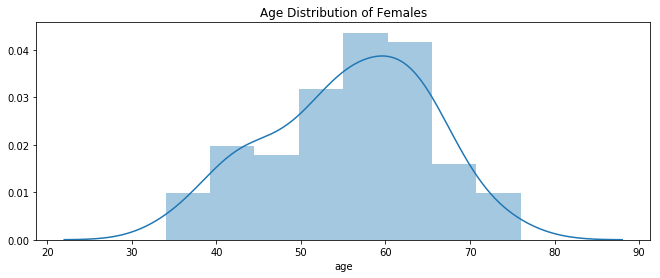

In [12]:
plt.figure(figsize=(11,4))
sns.distplot(all_females['age']).set_title('Age Distribution of Females')


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Age Distribution of Males')

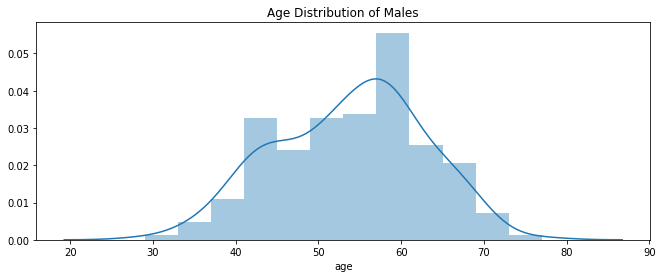

In [13]:
plt.figure(figsize = (11,4))
sns.distplot( all_males['age']).set_title('Age Distribution of Males')

From the plots we can see that males tend to report symptoms of heart disease at an earlier age than women. The distritbuition peaks in the late 50's for males and in the early 60's for females.  

Now let's observe if the chest pains differ between genders.

Text(0.5, 1.0, 'Chest Pain Types Reported By Females')

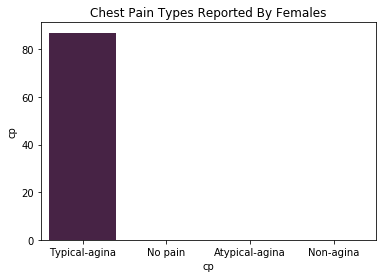

In [14]:
sns.barplot(x = all_females['cp'],y = data['cp'].value_counts(),palette = "rocket").set_title('Chest Pain Types Reported By Females')

Text(0.5, 1.0, 'Chest Pain Types Reported By Males')

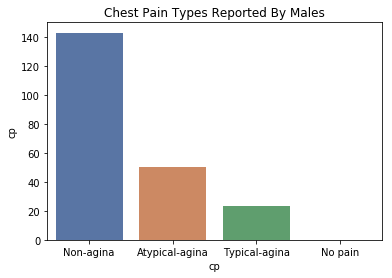

In [15]:
sns.barplot(x = all_males['cp'],y = data['cp'].value_counts(),palette = "deep").set_title('Chest Pain Types Reported By Males')

Now isn't that strange? All females reported the same type of chest pain, typical agina, while males reported three types of chest pain. Another take away here is that typical-agina, the only reported pain amongst females, is the least reported pain among males.

Next, lets look at how the maximum heart rates of the genders compare.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Maximum Heart Rate')

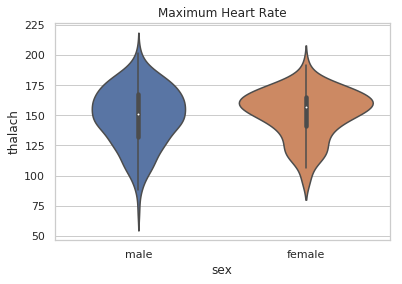

In [16]:
sns.set(style = "whitegrid")
sns.violinplot(x = intuitive['sex'], y = intuitive['thalach']).set_title("Maximum Heart Rate")


The median values and probability densities for the median for both genders are nearly the same, which is to be expected. One thing to notice though is that males only have one peak at the median. Females, on the other hand, have a second peak near the 125 bpm range. This peak at a lower heart rate is most likely linked to the typical agina pain that all the women had.  

The last two pieces of analysis confirm there is a noticble difference between male and female symptoms. It would be wise to re-analyze the correlations but in a gender specific way.

Text(0.5, 1.0, 'Correlation For Females')

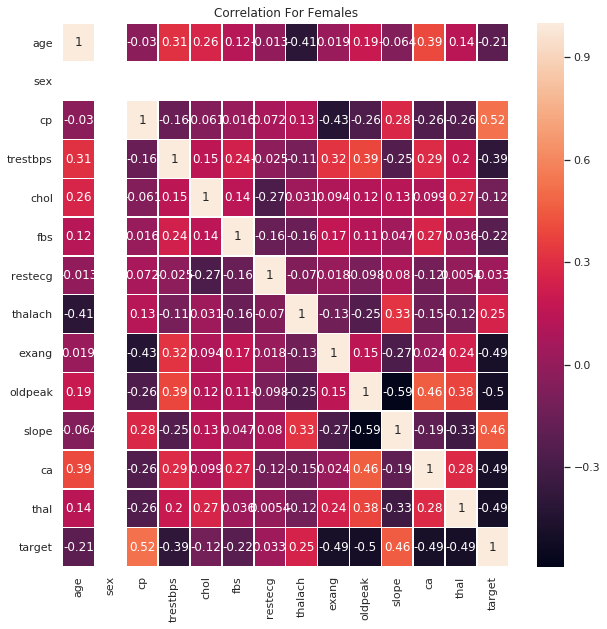

In [17]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(data[is_female].corr(), annot = True, linewidths=.5, ax = ax).set_title("Correlation For Females")

Text(0.5, 1.0, 'Correlation For Males')

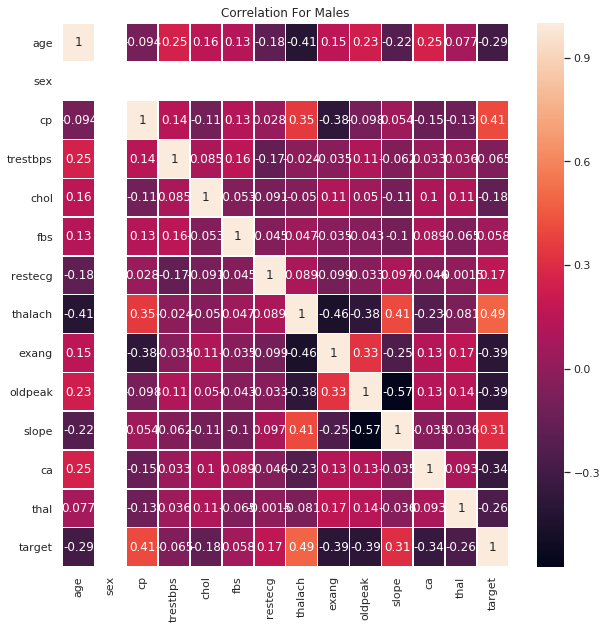

In [18]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(data[is_male].corr(), annot = True, linewidths=.5, ax = ax).set_title("Correlation For Males")

Though not strikingly different from the original correlation heat map, we do notice a few things. Chest pain has a higher correlation to the females' diagnosis than males. Also, maximum heart rate was not the second most significant correlation for the diagnosis of females, it was slope which measures peak performance of exercise. What does this mean? Typical-agina pain is often induced through strenuous activity, including excercise. Since our data shows that females are extremely likely to feel this kind of pain we can infer that older females who exercise put themselves at risk of inducing chest pain.

From our analysis we were able to make some very interesting observations. Now that we're familiar enough with the data, it's time to model it.

**Preparing for modeling**

Before we start jumping into modeling I'd like to take one more look at the data.

In [19]:
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


There is one problem here, the rows are sorted so that all target scores of 1 are on the top and the rows with target score 0 is on the bottom.This will complicate the construction of our training and testing sets. There are two ways out of this mess: 1) We can randomly select rows in an undefined order  2) We can shuffle the rows data frame in place. I'll go with the second option for simplicity.

In [20]:
data = data.sample(frac=1).reset_index(drop=True)

Now that our data frame is shuffled we can simply split the data as we please. One thing to keep in mind is that since we shuffle the data each time we run the notebook our statistic scores will differ with every run, though they should not vary drastically.  

In [21]:
data.var()

age           82.484558
sex            0.217166
cp             1.065132
trestbps     307.586453
chol        2686.426748
fbs            0.126877
restecg        0.276528
thalach      524.646406
exang          0.220707
oldpeak        1.348095
slope          0.379735
ca             1.045724
thal           0.374883
target         0.248836
dtype: float64

Now that the data has been shuffled, we are ready to find the best model for our problem.

**K-Fold Cross Validation** 

We are dealing with a binary classification problem that is not neccisarily well separated. If I had to guess, I'd say our best bet would be logistic regression but lets quantify that theory against two other popular classification models. K-fold cross validation can help out with that. In this case we will be using 5-fold cross validation.

In [22]:
cols = ['age','sex','cp','trestbps','chol','fbs','restecg','exang','oldpeak','slope','ca','thal']
goal = ['target']

logic_score = cross_val_score(LogisticRegression(), data[cols], data[goal], cv = 5,scoring = 'accuracy')
svc_lin_score = cross_val_score(SVC(kernel = 'linear', C = 1), data[cols], data[goal], cv = 5,scoring = 'accuracy')
tree_score = cross_val_score(tree(random_state = 0), data[cols], data[goal], cv = 5,scoring = 'accuracy')


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:43

In [23]:
logic_score.mean()

0.8253551912568305

In [24]:
svc_lin_score.mean()

0.8319125683060109

In [25]:
tree_score.mean()

0.7561748633879781

It turns out my prediction was partially right. Support vector classification has nearly the same accuracy score as logistic regression. Let's try out both!
First let's build our logistic model.

**Logistic Regression**

In [26]:
train,test = np.split(data,[data['age'].count() // 2],axis = 0)
X_train = train[cols]
y_train = train[goal]
X_test = test[cols]
y_test = test[goal]
logistic = LogisticRegression()

logistic.fit(X_train, y_train)
predict = logistic.predict(X_test)
proba = logistic.predict_proba(X_test)
mse = mean_squared_error(y_test,predict)
accuracy_score = logistic.score(X_test,y_test)
print('Logistic Mean Squared Error:', mse)
print('Logistic Accuracy Score:',accuracy_score)

Logistic Mean Squared Error: 0.14473684210526316
Logistic Accuracy Score: 0.8552631578947368


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


If our cross validation didn't fail us, we should get similar scores for the SVC.

**Support Vector Classification**

In [27]:
svc = SVC(kernel = 'linear', C = 1)
svc.fit(X_train,y_train)
svc_predict = svc.predict(X_test)
svc_mse = mean_squared_error(y_test,svc_predict)
svc_accuracy_score = svc.score(X_test,y_test)

print('Support Vector Classification MSE:',svc_mse)
print('Support Vector Classification ACC:',svc_accuracy_score)


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Support Vector Classification MSE: 0.14473684210526316
Support Vector Classification ACC: 0.8552631578947368


Cross-Validation has not failed us! Both models have roughly the same MSE and accuracy score. We can use both models to predict the diagnosis of patients with an accuracy of ~80%. 

However, I feel we can do better.


**Gradient Boosting**

The xgboost library can help us develop a more accurate model using gradient boosting. 

In [28]:
from xgboost import XGBRegressor

In [29]:
xgb = XGBRegressor(n_estimators = 100)
xgb.fit(X_train ,y= y_train)
xgb_predict = xgb.predict(X_test)
xgb_mse = mean_squared_error(xgb_predict,y_test)
print('Gradient boosting MSE:',xgb_mse)

Gradient boosting MSE: 0.13772580812683105


The MSE for gradient boosting is slightly lower than our previous two models thus increasing our accuracy.